This will add attention at the middle, maybe feature importance?
Not done yet

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [3]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding with validation"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for i, seq in enumerate(sequences):
        try:
            if pd.isna(seq):
                print(f"Warning: Found null sequence at index {i}")
                continue
            if not isinstance(seq, str):
                print(f"Warning: Non-string sequence at index {i}: {type(seq)}")
                continue
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence at index {i}: {str(e)}")
            print(f"Sequence: {seq}")
            continue
    
    encodings = np.array(encodings, dtype=np.float32)
    print(f"Sequence data shape: {encodings.shape}")
    return encodings

In [4]:
def prepare_structure_data(df):
    """Enhanced feature preparation with validation"""
    def normalize_angles(angle_array):
        angle_rad = np.pi * angle_array / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    features_list = []
    
    # Process angles
    angles = ['phi', 'psi', 'omega', 'tau']
    for angle in angles:
        try:
            angle_arrays = np.array([np.array(eval(x)) for x in df[angle]])
            angle_features = normalize_angles(angle_arrays)
            features_list.append(angle_features)
        except Exception as e:
            print(f"Error processing {angle}: {str(e)}")
            raise
    
    # Process SASA
    try:
        sasa_arrays = np.array([np.array(eval(x)) for x in df['sasa']])
        scaler = RobustScaler()
        sasa_flat = sasa_arrays.reshape(-1, 1)
        sasa_scaled = scaler.fit_transform(sasa_flat).reshape(sasa_arrays.shape)
        features_list.append(sasa_scaled[..., np.newaxis])
    except Exception as e:
        print(f"Error processing SASA: {str(e)}")
        raise
    
    # Process secondary structure
    try:
        ss_arrays = np.array([list(seq) for seq in df['ss']])
        ss_encoded = np.zeros((len(ss_arrays), ss_arrays.shape[1], 3))
        ss_map = {'H': 0, 'E': 1, 'L': 2}
        for i in range(len(ss_arrays)):
            for j in range(len(ss_arrays[i])):
                ss_encoded[i, j, ss_map[ss_arrays[i, j]]] = 1
        features_list.append(ss_encoded)
    except Exception as e:
        print(f"Error processing secondary structure: {str(e)}")
        raise
    
    features = np.concatenate(features_list, axis=-1)
    features = features.astype(np.float32)
    print(f"Structure data shape: {features.shape}")
    return features

In [5]:
def create_combined_model(seq_length=33, struct_features=12, struct_window=0):
    """Create model with attention focused on middle position structural features"""
    # Calculate sizes
    struct_positions = 1 + (2 * struct_window)
    middle_pos = seq_length // 2
    total_struct_features = struct_positions * struct_features
    struct_dense_size = min(total_struct_features * 2, 128)
    
    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='same')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu', name='seq_features')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)
    
    # Structure track - focus only on middle position
    struct_input = tf.keras.layers.Input(shape=(seq_length, struct_features), name='structure_input')
    
    # Extract middle position features
    x_struct = tf.keras.layers.Lambda(
        lambda x: x[:, middle_pos:middle_pos+1, :]
    )(struct_input)
    
    # Process middle position features with dynamic size
    x_struct = tf.keras.layers.Dense(32, activation='relu')(x_struct)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    x_struct = tf.keras.layers.Flatten()(x_struct)
    x_struct = tf.keras.layers.Dense(struct_dense_size, activation='relu', name='struct_features')(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    
    # Combine features
    combined = tf.keras.layers.Concatenate(name='combined_features')([x_seq, x_struct])
    
    # Attention mechanism
    attention = tf.keras.layers.Dense(64, activation='tanh', name='attention_dense1')(combined)
    attention = tf.keras.layers.Dense(1, activation='sigmoid', name='attention_weights')(attention)
    attended_features = tf.keras.layers.Multiply(name='attention_applied')([combined, attention])
    
    # Final layers
    x = tf.keras.layers.Dense(32, activation='relu')(attended_features)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[seq_input, struct_input], outputs=outputs)
    
    def get_attention_weights():
        """Get attention weights focusing on middle position features"""
        try:
            dense1_weights = model.get_layer('attention_dense1').get_weights()[0]
            dense2_weights = model.get_layer('attention_weights').get_weights()[0]
            
            combined_weights = np.abs(np.dot(dense1_weights, dense2_weights)).flatten()
            normalized_weights = combined_weights / np.sum(combined_weights)
            
            seq_weights = normalized_weights[:32]
            struct_weights = normalized_weights[32:32+struct_dense_size]
            
            feature_names = [
                'phi_sin', 'phi_cos',
                'psi_sin', 'psi_cos',
                'omega_sin', 'omega_cos',
                'tau_sin', 'tau_cos',
                'sasa',
                'ss_H', 'ss_E', 'ss_L'
            ]
            
            # Create dictionary for middle position features
            struct_dict = {}
            weights_per_feature = struct_dense_size // len(feature_names)
            for i, feat_name in enumerate(feature_names):
                key = f"middle_{feat_name}"
                weight_index = i * weights_per_feature
                struct_dict[key] = float(np.mean(struct_weights[weight_index:weight_index + weights_per_feature]))
            
            return {
                'sequence_importance': float(np.mean(seq_weights)),
                'structure_importance': float(np.mean(struct_weights)),
                'feature_weights': {
                    'sequence': list(seq_weights),
                    'structure': struct_dict
                }
            }
        except Exception as e:
            print(f"Error getting attention weights: {str(e)}")
            return None
    
    model.get_attention_weights = get_attention_weights
    
    return model

In [6]:
def plot_attention_weights(attention_info, fold=None):
    """Plot attention weights analysis"""
    if attention_info:
        plt.figure(figsize=(15, 10))
        
        # Plot track weights
        plt.subplot(2, 2, 1)
        track_weights = attention_info['track_weights']
        plt.bar(['Sequence', 'Structure'], 
                [track_weights['sequence'], track_weights['structure']])
        plt.title('Track Weights')
        plt.ylabel('Weight')
        
        # Plot sequence feature importance
        plt.subplot(2, 2, 2)
        seq_weights = attention_info['feature_weights']['sequence']
        plt.bar(range(len(seq_weights)), seq_weights)
        plt.title('Sequence Feature Importance')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
        
        # Plot structure feature importance
        plt.subplot(2, 1, 2)
        struct_features = attention_info['feature_weights']['structure']
        plt.bar(range(len(struct_features)), list(struct_features.values()))
        plt.xticks(range(len(struct_features)), list(struct_features.keys()), rotation=90)
        plt.title('Structure Feature Importance by Position')
        plt.ylabel('Importance')
        
        plt.tight_layout()
        # if fold is not None:
        #     plt.savefig(f'attention_weights_fold_{fold}.png')
        plt.show()

In [7]:
def plot_attention_weights(attention_info, fold=None):
    """Plot attention weights analysis"""
    if attention_info:
        plt.figure(figsize=(15, 10))
        
        # Plot track weights
        plt.subplot(2, 2, 1)
        track_weights = {'sequence': attention_info['sequence_importance'],
                        'structure': attention_info['structure_importance']}
        plt.bar(['Sequence', 'Structure'], 
                [track_weights['sequence'], track_weights['structure']])
        plt.title('Track Importance')
        plt.ylabel('Weight')
        
        # Plot sequence feature importance
        plt.subplot(2, 2, 2)
        seq_weights = attention_info['feature_weights']['sequence']
        plt.bar(range(len(seq_weights)), seq_weights)
        plt.title('Sequence Feature Importance')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
        
        # Plot structure feature importance at middle position
        plt.subplot(2, 1, 2)
        struct_features = attention_info['feature_weights']['structure']
        feature_names = list(struct_features.keys())
        feature_weights = list(struct_features.values())
        plt.bar(range(len(feature_weights)), feature_weights)
        plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
        plt.title('Structure Feature Importance at Middle Position')
        plt.ylabel('Importance')
        
        plt.tight_layout()
        if fold is not None:
            plt.savefig(f'attention_weights_fold_{fold}.png')
        plt.show()

In [8]:
def train_and_evaluate(struct_window=0):
    """Training function with middle position attention analysis"""
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../data/processed_data_train_after.csv")
    test_df = pd.read_csv("../data/processed_data_test_after.csv")
    
    # Prepare data
    X_train_seq = prepare_sequence_data(train_df)
    X_test_seq = prepare_sequence_data(test_df)
    X_train_struct = prepare_structure_data(train_df)
    X_test_struct = prepare_structure_data(test_df)
    
    y_train = train_df['label'].values.astype(np.float32)
    y_test = test_df['label'].values.astype(np.float32)
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            mode='min'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            mode='min',
            verbose=1
        )
    ]
    
    # Cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    attention_history = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\nFold {fold}/5")
        
        model = create_combined_model(
            seq_length=33,
            struct_features=X_train_struct.shape[2],
            struct_window=struct_window
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        history = model.fit(
            [X_train_seq[train_idx], X_train_struct[train_idx]],
            y_train[train_idx],
            validation_data=(
                [X_train_seq[val_idx], X_train_struct[val_idx]],
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Evaluate fold
        y_pred = model.predict([X_train_seq[val_idx], X_train_struct[val_idx]])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))
        
        # Get and store attention weights
        attention_info = model.get_attention_weights()
        attention_history.append(attention_info)
        
        print(f"\nFold {fold} Results:")
        print(f"ACC: {metrics['acc'][-1]:.4f}")
        print(f"BALANCED_ACC: {metrics['balanced_acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"SN: {metrics['sn'][-1]:.4f}")
        print(f"SP: {metrics['sp'][-1]:.4f}")
        
        # Plot attention weights using the updated plotting function
        plot_attention_weights(attention_info, fold)
        
        # Plot training curves
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Loss - Fold {fold}')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Accuracy - Fold {fold}')
        plt.legend()
        plt.show()
        
        # Store test predictions
        test_pred = model.predict([X_test_seq, X_test_struct])
        test_predictions.append(test_pred)
    
    # Print final cross-validation results
    print("\nFinal Cross-validation Results:")
    for metric in metrics:
        mean_val = np.mean(metrics[metric])
        std_val = np.std(metrics[metric])
        print(f"{metric.upper()}: {mean_val:.4f} ± {std_val:.4f}")
    
    # Calculate and print average feature importance
    if attention_history:
        # Track importance
        seq_importance = np.mean([info['sequence_importance'] for info in attention_history])
        struct_importance = np.mean([info['structure_importance'] for info in attention_history])
        print(f"\nAverage Track Importance:")
        print(f"Sequence: {seq_importance:.4f} ± "
              f"{np.std([info['sequence_importance'] for info in attention_history]):.4f}")
        print(f"Structure: {struct_importance:.4f} ± "
              f"{np.std([info['structure_importance'] for info in attention_history]):.4f}")
        
        # Feature importance at middle position
        print("\nStructure Features at Middle Position:")
        struct_features = attention_history[0]['feature_weights']['structure']
        for feature in struct_features:
            values = [info['feature_weights']['structure'][feature] for info in attention_history]
            mean_val = np.mean(values)
            std_val = np.std(values)
            print(f"{feature}: {mean_val:.4f} ± {std_val:.4f}")
    
    # Calculate ensemble predictions
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Final test set evaluation
    final_cm = confusion_matrix(y_test, test_pred_binary)
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {final_cm[1][1]/(final_cm[1][1]+final_cm[1][0]):.4f}")
    print(f"Specificity: {final_cm[0][0]/(final_cm[0][0]+final_cm[0][1]):.4f}")
    
    return model, attention_history

Training model with window size: 0
This will consider 1 positions centered on the target residue
Loading data...
Sequence data shape: (8850, 33)
Sequence data shape: (2737, 33)
Structure data shape: (8850, 33, 12)
Structure data shape: (2737, 33, 12)

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-03 22:50:47.482216: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-03 22:50:47.482235: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-03 22:50:47.482242: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-03 22:50:47.482257: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-03 22:50:47.482269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-12-03 22:50:48.271173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5122 - loss: 0.6948 - val_accuracy: 0.5322 - val_loss: 0.6919 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5318 - loss: 0.6897 - val_accuracy: 0.5797 - val_loss: 0.6799 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5787 - loss: 0.6697 - val_accuracy: 0.7017 - val_loss: 0.5988 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6874 - loss: 0.5877 - val_accuracy: 0.7311 - val_loss: 0.5520 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7259 - loss: 0.5508 - val_accuracy: 0.7294 - val_loss: 0.5399 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7426 - loss: 0.5392 - val_accuracy: 0.7412 - val_loss: 0.5289 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7

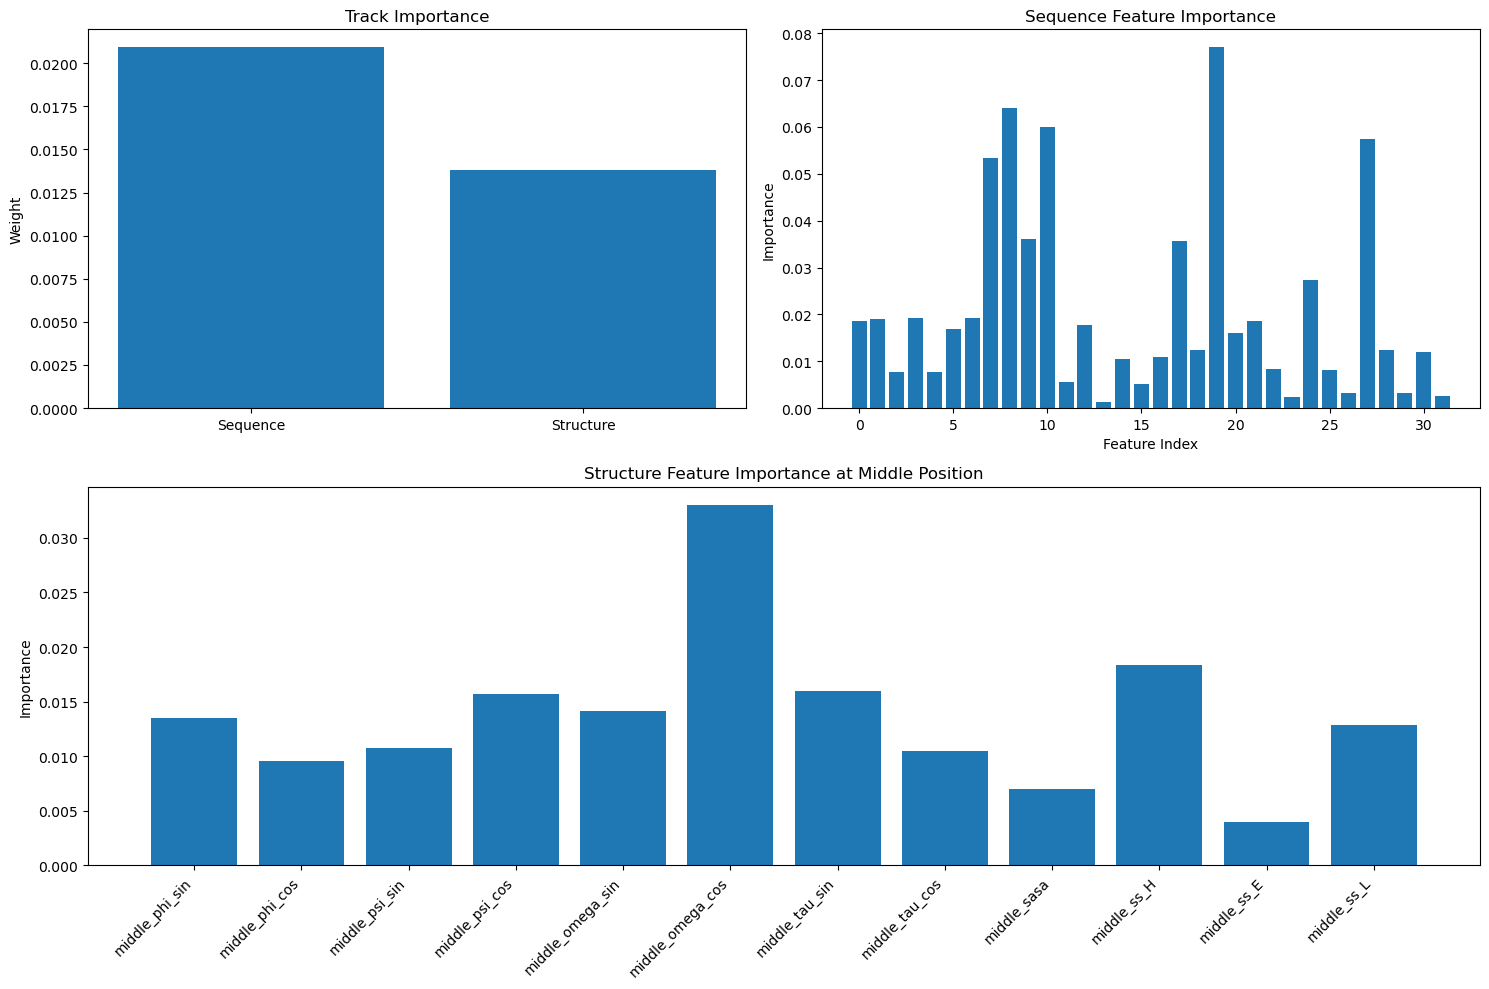

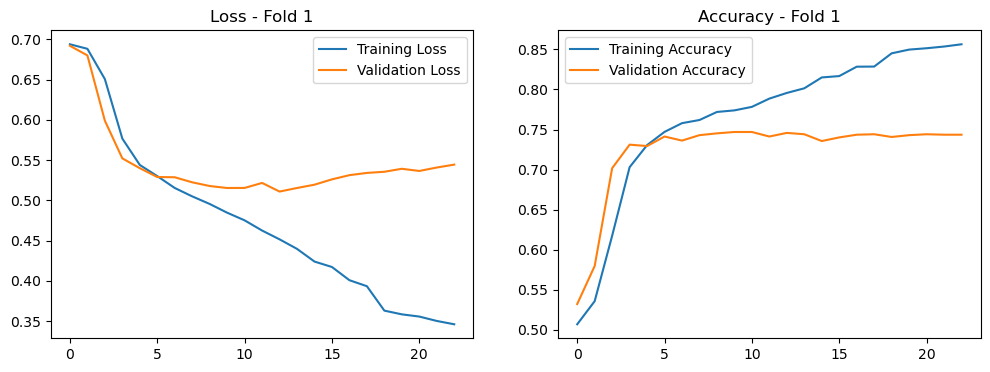

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4900 - loss: 0.6977 - val_accuracy: 0.5186 - val_loss: 0.6931 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.4962 - loss: 0.6932 - val_accuracy: 0.5158 - val_loss: 0.6932 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.4990 - loss: 0.6929 - val_accuracy: 0.4887 - val_loss: 0.6932 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.4816 - loss: 0.6929 - val_accuracy: 0.4921 - val_loss: 0.6946 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.4994 - loss: 0.6936 - val_accuracy: 0.5458 - val_loss: 0.6927 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5142 - loss: 0.6919 - val_accuracy: 0.5599 - val_loss: 0.6909 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.53

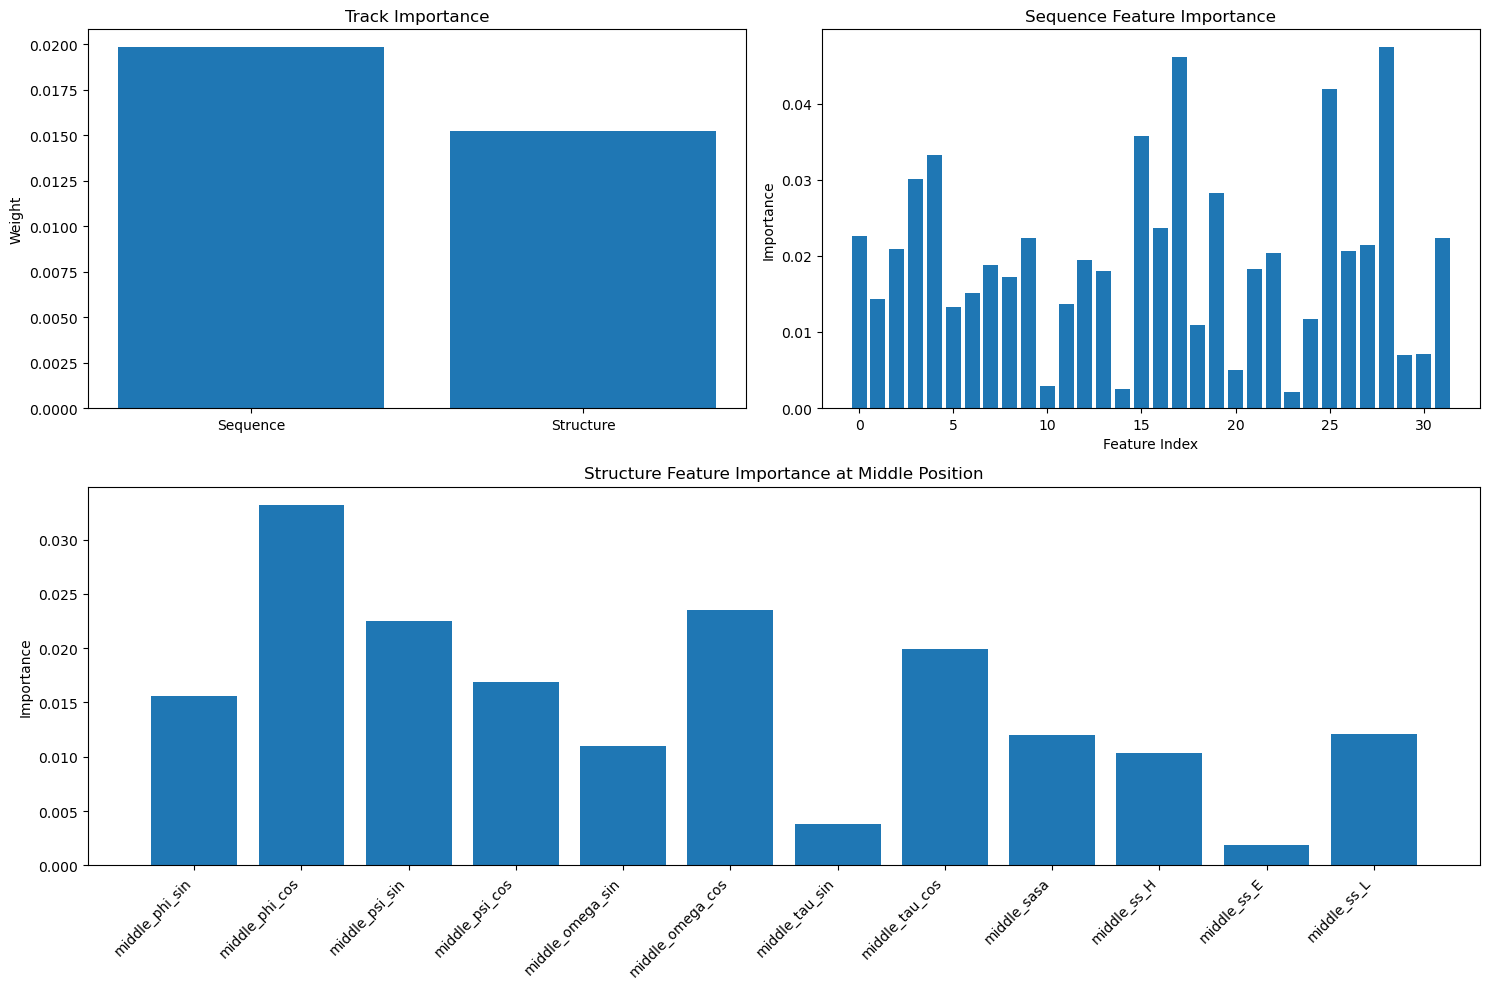

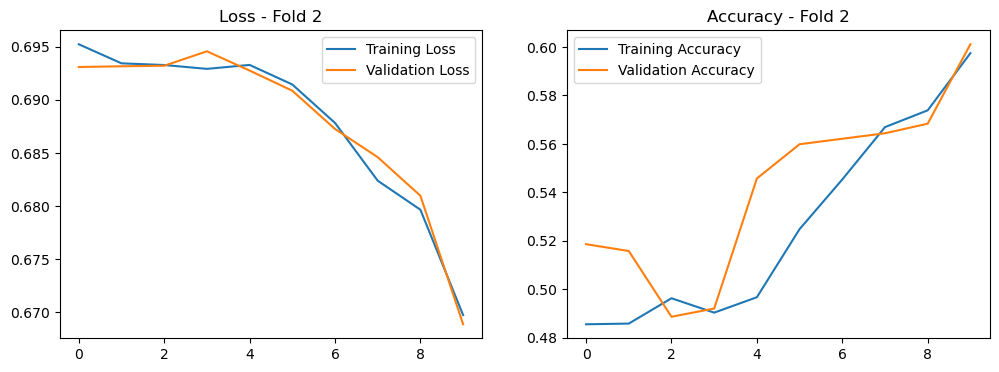

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4930 - loss: 0.6976 - val_accuracy: 0.5254 - val_loss: 0.6929 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5189 - loss: 0.6926 - val_accuracy: 0.5254 - val_loss: 0.6913 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5239 - loss: 0.6913 - val_accuracy: 0.5435 - val_loss: 0.6873 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5784 - loss: 0.6761 - val_accuracy: 0.6542 - val_loss: 0.6363 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6614 - loss: 0.6187 - val_accuracy: 0.7068 - val_loss: 0.5783 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7007 - loss: 0.5757 - val_accuracy: 0.7186 - val_loss: 0.5593 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.72

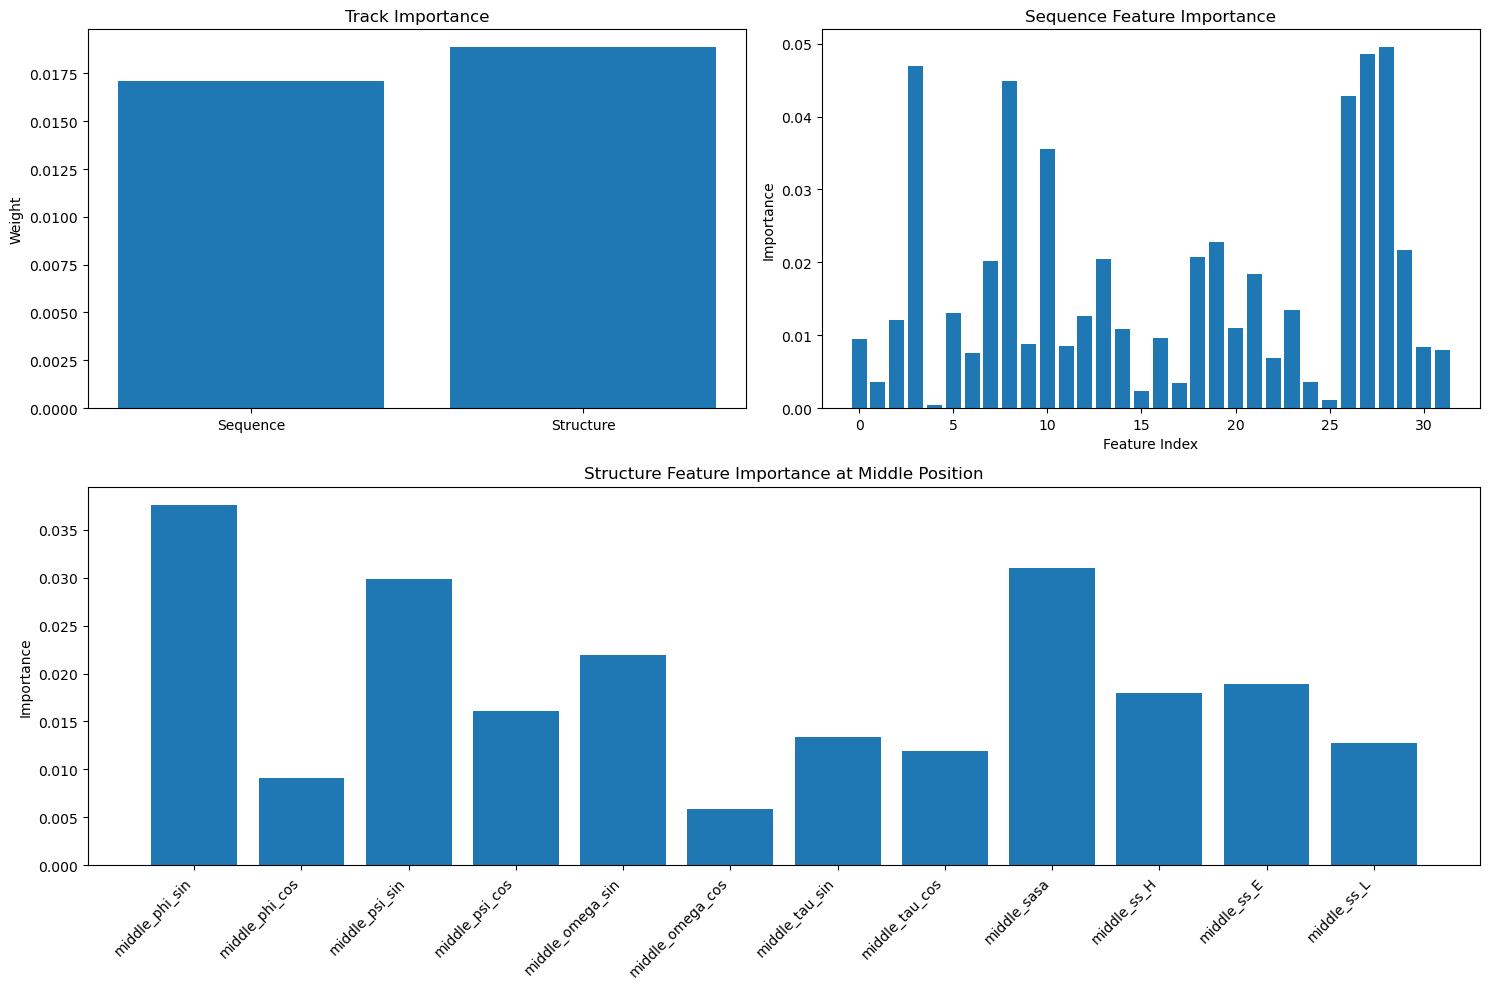

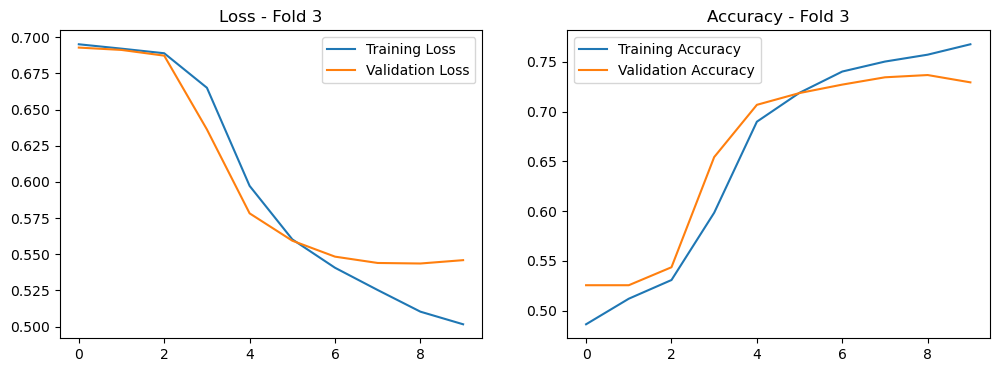

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.5075 - loss: 0.7012 - val_accuracy: 0.5175 - val_loss: 0.6928 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.4997 - loss: 0.6930 - val_accuracy: 0.5373 - val_loss: 0.6920 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5226 - loss: 0.6920 - val_accuracy: 0.5650 - val_loss: 0.6864 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5601 - loss: 0.6862 - val_accuracy: 0.5927 - val_loss: 0.6714 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5927 - loss: 0.6736 - val_accuracy: 0.6169 - val_loss: 0.6581 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6205 - loss: 0.6529 - val_accuracy: 0.6667 - val_loss: 0.6219 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6

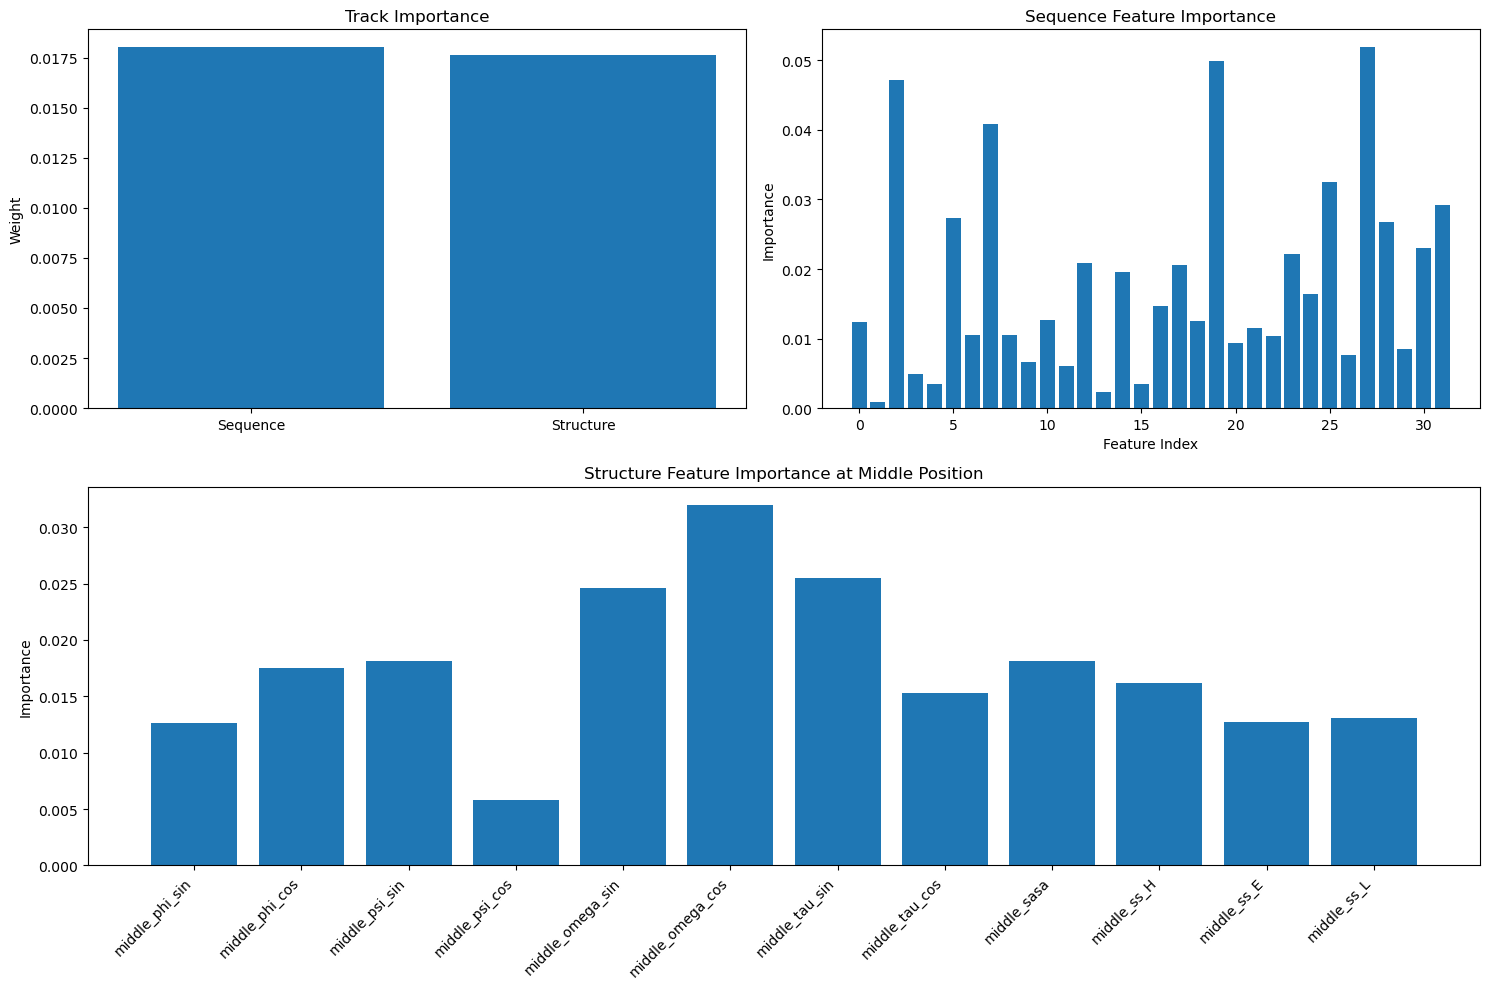

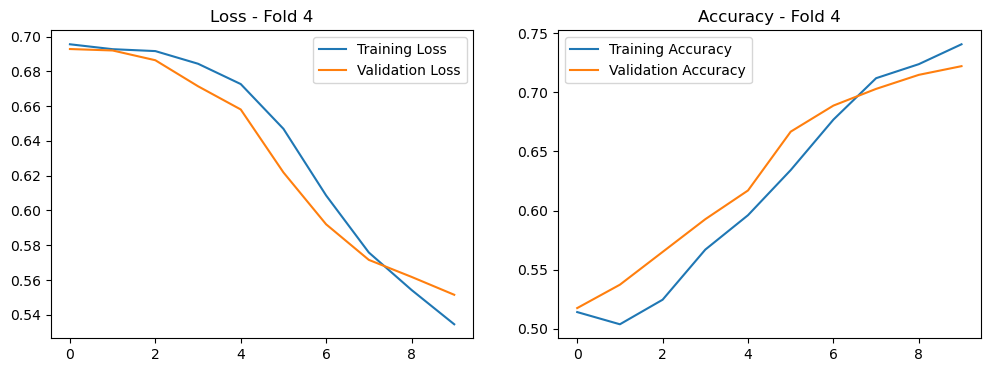

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5081 - loss: 0.6966 - val_accuracy: 0.5282 - val_loss: 0.6907 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5514 - loss: 0.6886 - val_accuracy: 0.5768 - val_loss: 0.6801 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5918 - loss: 0.6732 - val_accuracy: 0.6401 - val_loss: 0.6331 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6562 - loss: 0.6252 - val_accuracy: 0.6881 - val_loss: 0.5900 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6887 - loss: 0.5835 - val_accuracy: 0.7040 - val_loss: 0.5720 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7088 - loss: 0.5609 - val_accuracy: 0.7164 - val_loss: 0.5616 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.72

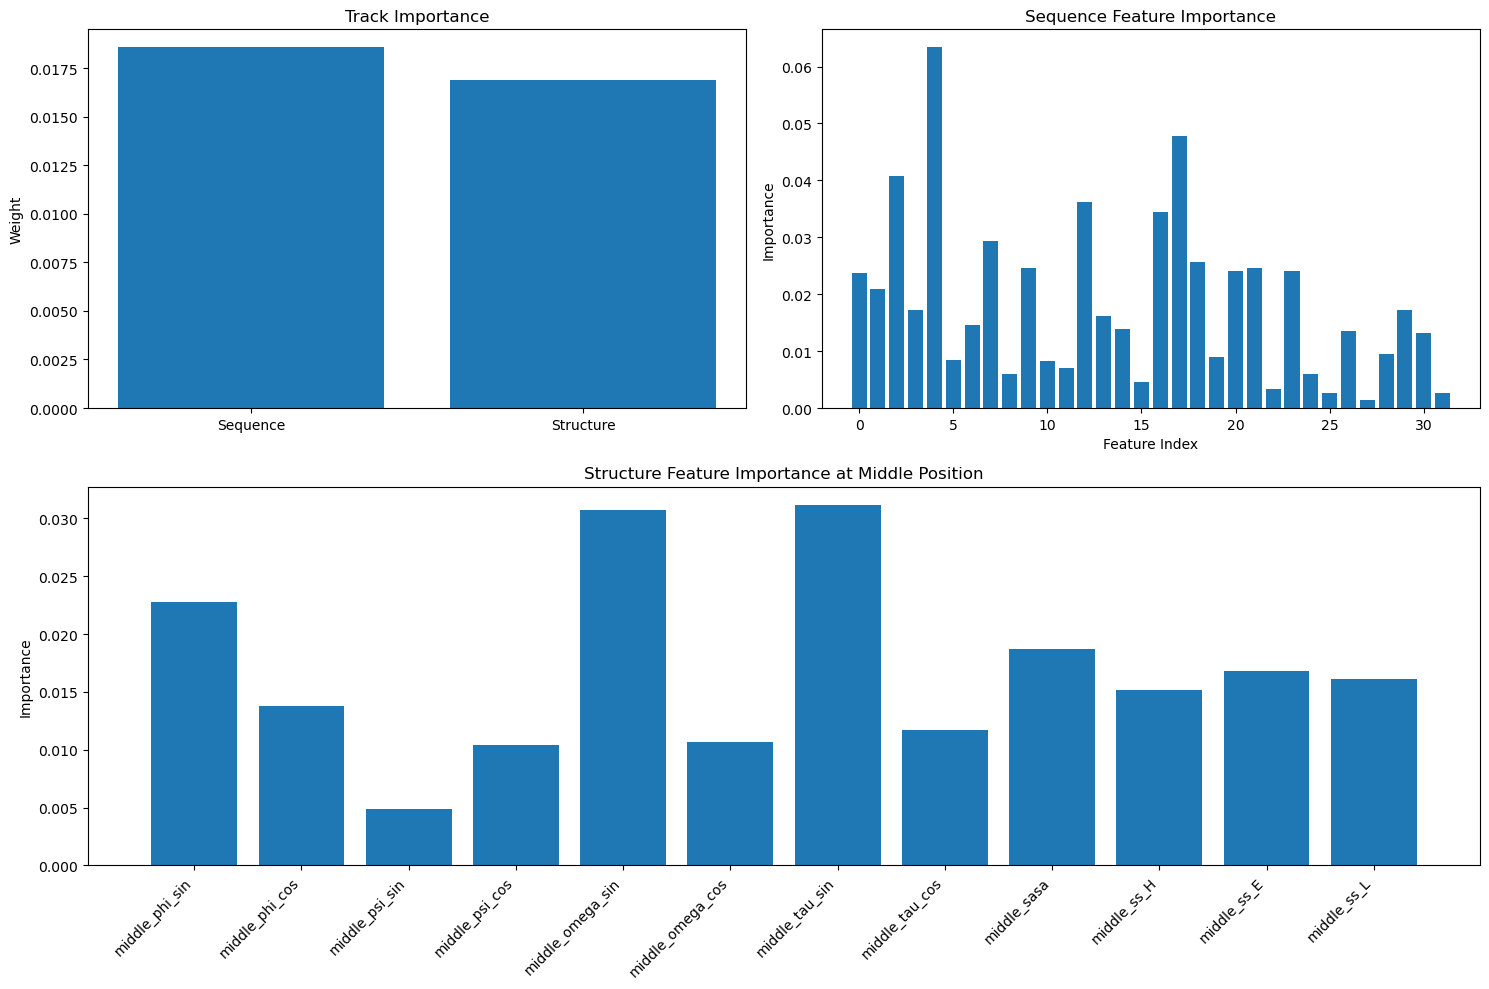

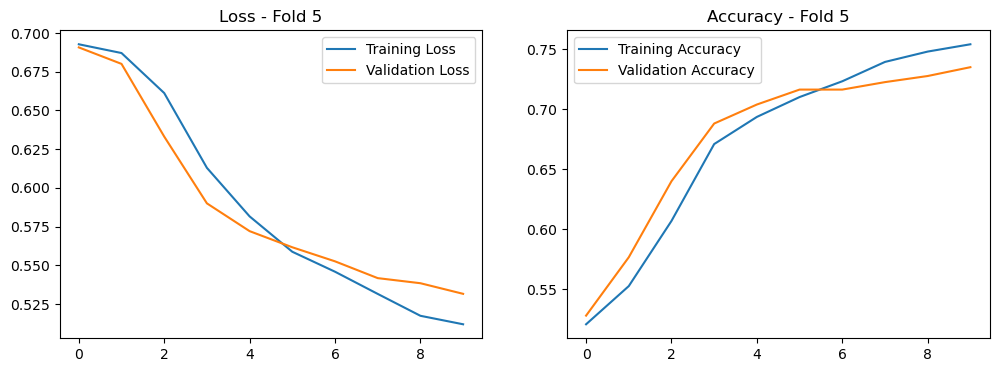

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Final Cross-validation Results:
ACC: 0.5671 ± 0.0894
BALANCED_ACC: 0.5579 ± 0.0928
MCC: 0.1231 ± 0.1865
SN: 0.8032 ± 0.1310
SP: 0.3125 ± 0.2207

Average Track Importance:
Sequence: 0.0189 ± 0.0013
Structure: 0.0165 ± 0.0018

Structure Features at Middle Position:
middle_phi_sin: 0.0204 ± 0.0093
middle_phi_cos: 0.0166 ± 0.0088
middle_psi_sin: 0.0172 ± 0.0087
middle_psi_cos: 0.0130 ± 0.0043
middle_omega_sin: 0.0205 ± 0.0071
middle_omega_cos: 0.0210 ± 0.0110
middle_tau_sin: 0.0180 ± 0.0096
middle_tau_cos: 0.0139 ± 0.0034
middle_sasa: 0.0174 ± 0.0081
middle_ss_H: 0.0156 ± 0.0029
middle_ss_E: 0.0109 ± 0.0068
middle_ss_L: 0.0134 ± 0.0014

Final Test Set Results:
Accuracy: 0.6613
Balanced Accuracy: 0.7447
MCC: 0.2826
Sensitivity: 0.8458
Specificity: 0.6436


In [9]:
if __name__ == "__main__":
    # Set window size
    window_size = 0  # or any other size you want to try
    print(f"Training model with window size: {window_size}")
    print(f"This will consider {2*window_size + 1} positions centered on the target residue")
    
    # Train model
    model, attention_history = train_and_evaluate(struct_window=window_size)

Training model with window size: 1
This will consider 3 positions centered on the target residue
Loading data...
Sequence data shape: (8850, 33)
Sequence data shape: (2737, 33)
Structure data shape: (8850, 33, 12)
Structure data shape: (2737, 33, 12)

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5144 - loss: 0.6932 - val_accuracy: 0.5130 - val_loss: 0.6912 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5336 - loss: 0.6903 - val_accuracy: 0.5469 - val_loss: 0.6825 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5888 - loss: 0.6731 - val_accuracy: 0.6797 - val_loss: 0.6174 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6721 - loss: 0.6092 - val_accuracy: 0.7237 - val_loss: 0.5680 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7118 - loss: 0.5621 - val_accuracy: 0.7243 - val_loss: 0.5466 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7363 - loss: 0.5379 - val_accuracy: 0.7367 - val_loss: 0.5312 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7

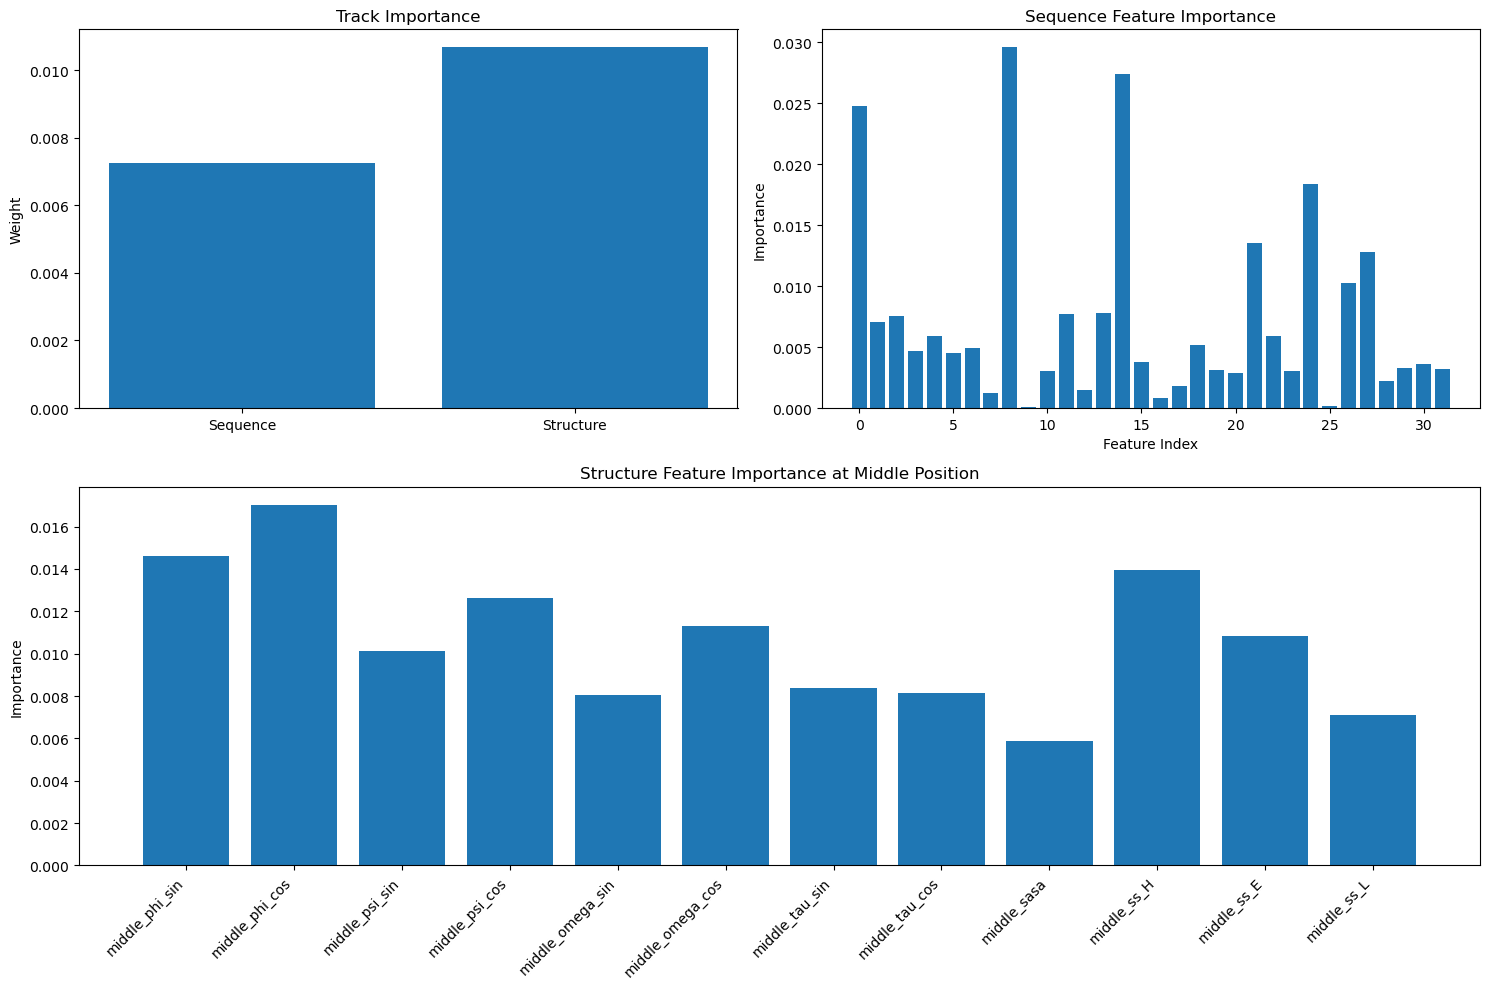

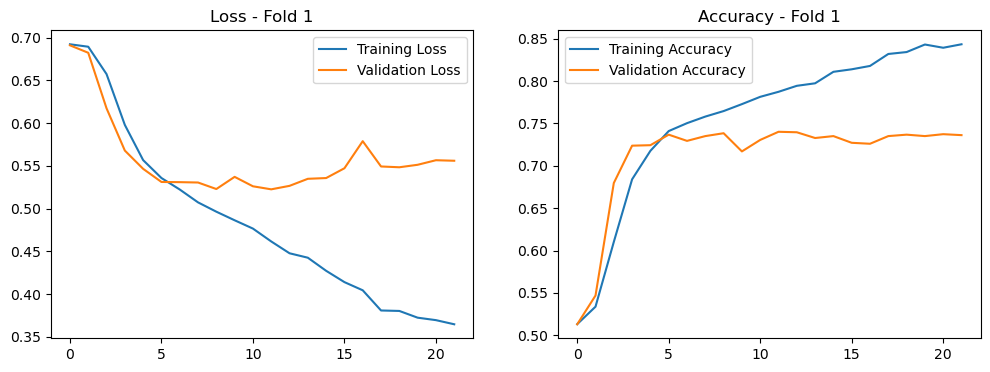

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5067 - loss: 0.6969 - val_accuracy: 0.5554 - val_loss: 0.6904 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5109 - loss: 0.6925 - val_accuracy: 0.5311 - val_loss: 0.6875 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5271 - loss: 0.6903 - val_accuracy: 0.6169 - val_loss: 0.6590 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6215 - loss: 0.6583 - val_accuracy: 0.6588 - val_loss: 0.6223 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6576 - loss: 0.6242 - val_accuracy: 0.6921 - val_loss: 0.5932 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6971 - loss: 0.5925 - val_accuracy: 0.7158 - val_loss: 0.5678 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.70

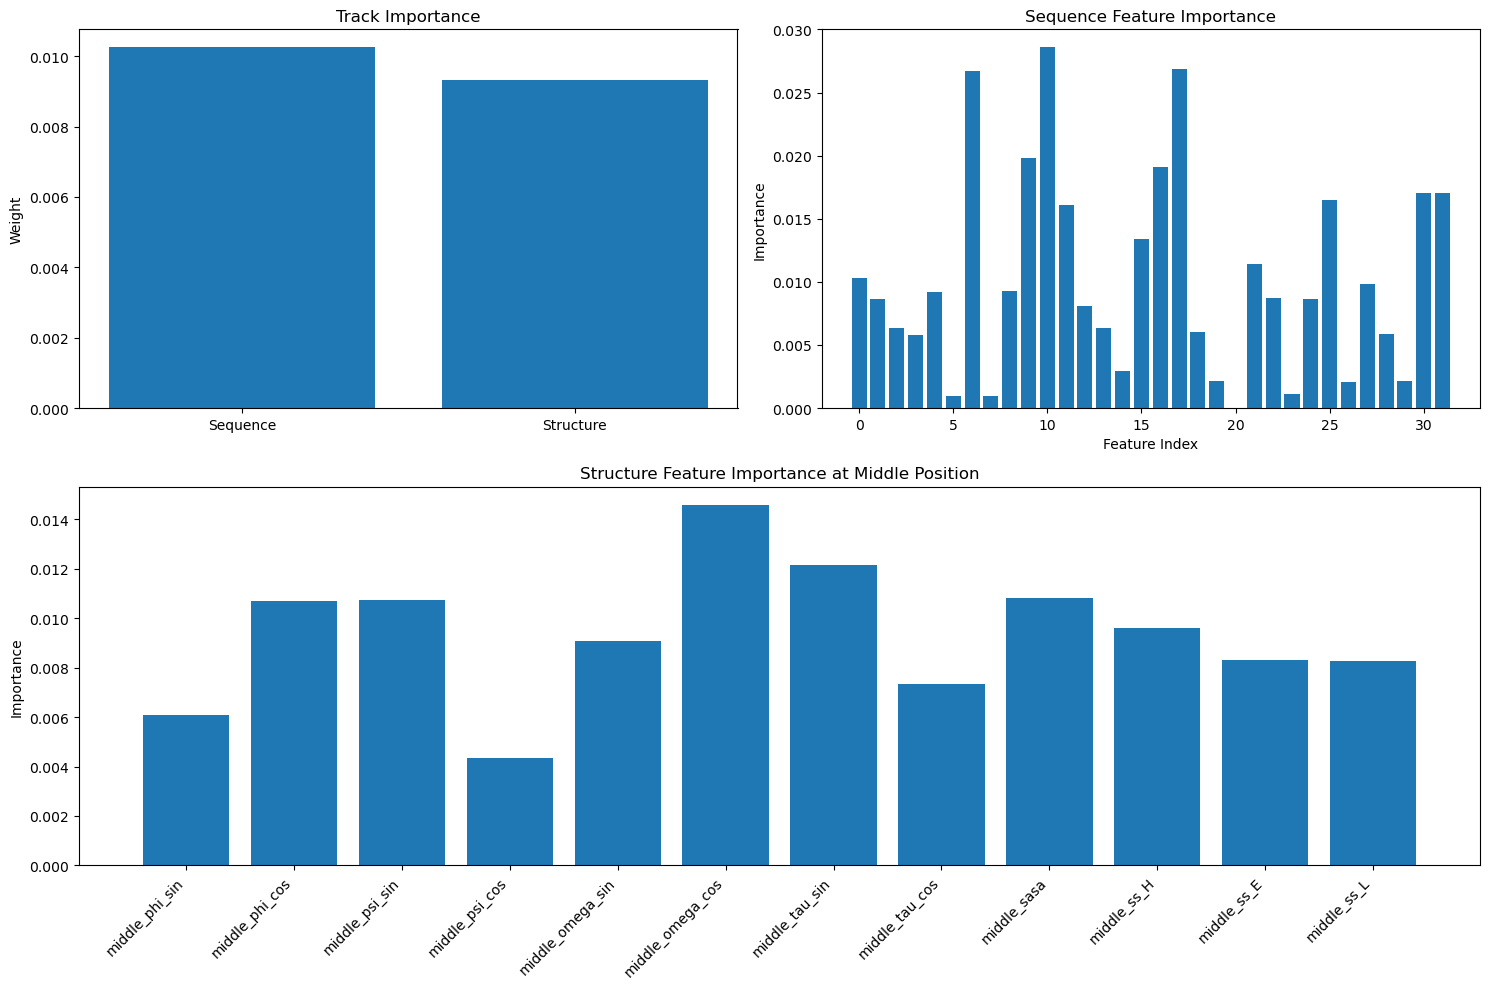

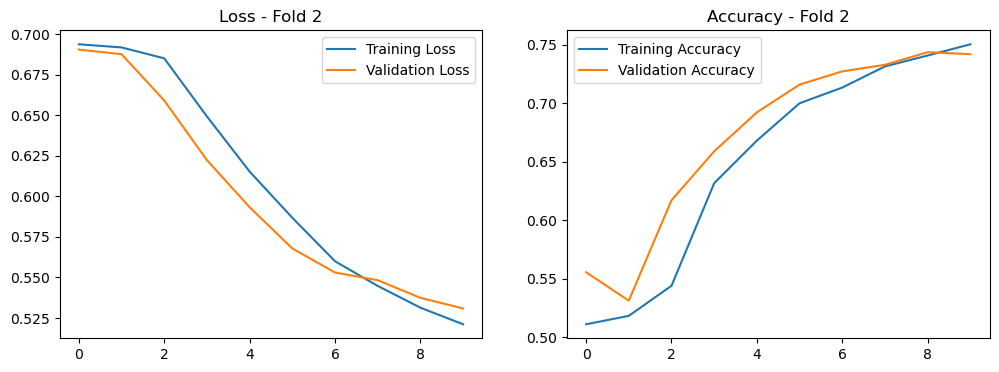

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.5088 - loss: 0.6947 - val_accuracy: 0.5282 - val_loss: 0.6909 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5369 - loss: 0.6894 - val_accuracy: 0.5458 - val_loss: 0.6883 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5522 - loss: 0.6877 - val_accuracy: 0.5531 - val_loss: 0.6870 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5705 - loss: 0.6775 - val_accuracy: 0.6616 - val_loss: 0.6230 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6647 - loss: 0.6139 - val_accuracy: 0.7034 - val_loss: 0.5791 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7033 - loss: 0.5712 - val_accuracy: 0.7181 - val_loss: 0.5571 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7

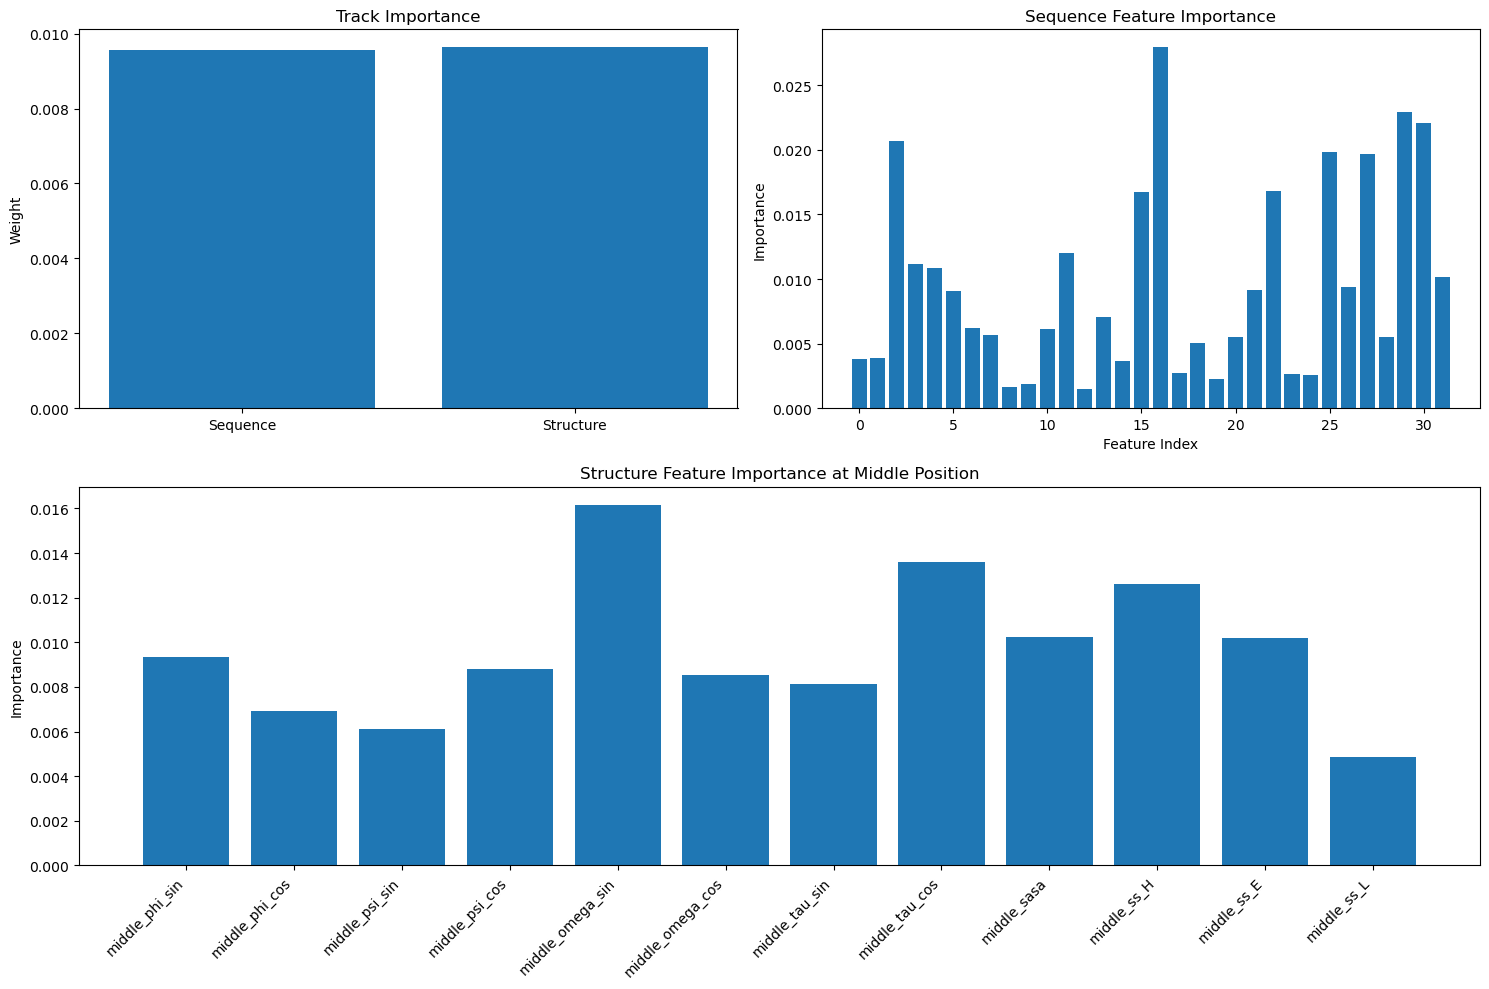

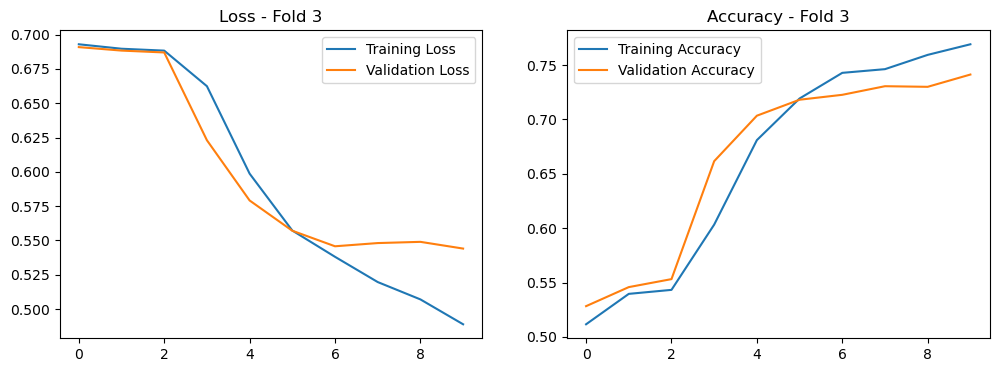

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4909 - loss: 0.6996 - val_accuracy: 0.5305 - val_loss: 0.6926 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5101 - loss: 0.6927 - val_accuracy: 0.5226 - val_loss: 0.6923 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5095 - loss: 0.6926 - val_accuracy: 0.5249 - val_loss: 0.6915 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5223 - loss: 0.6913 - val_accuracy: 0.5531 - val_loss: 0.6789 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5505 - loss: 0.6812 - val_accuracy: 0.6130 - val_loss: 0.6675 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6115 - loss: 0.6571 - val_accuracy: 0.6881 - val_loss: 0.5936 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.69

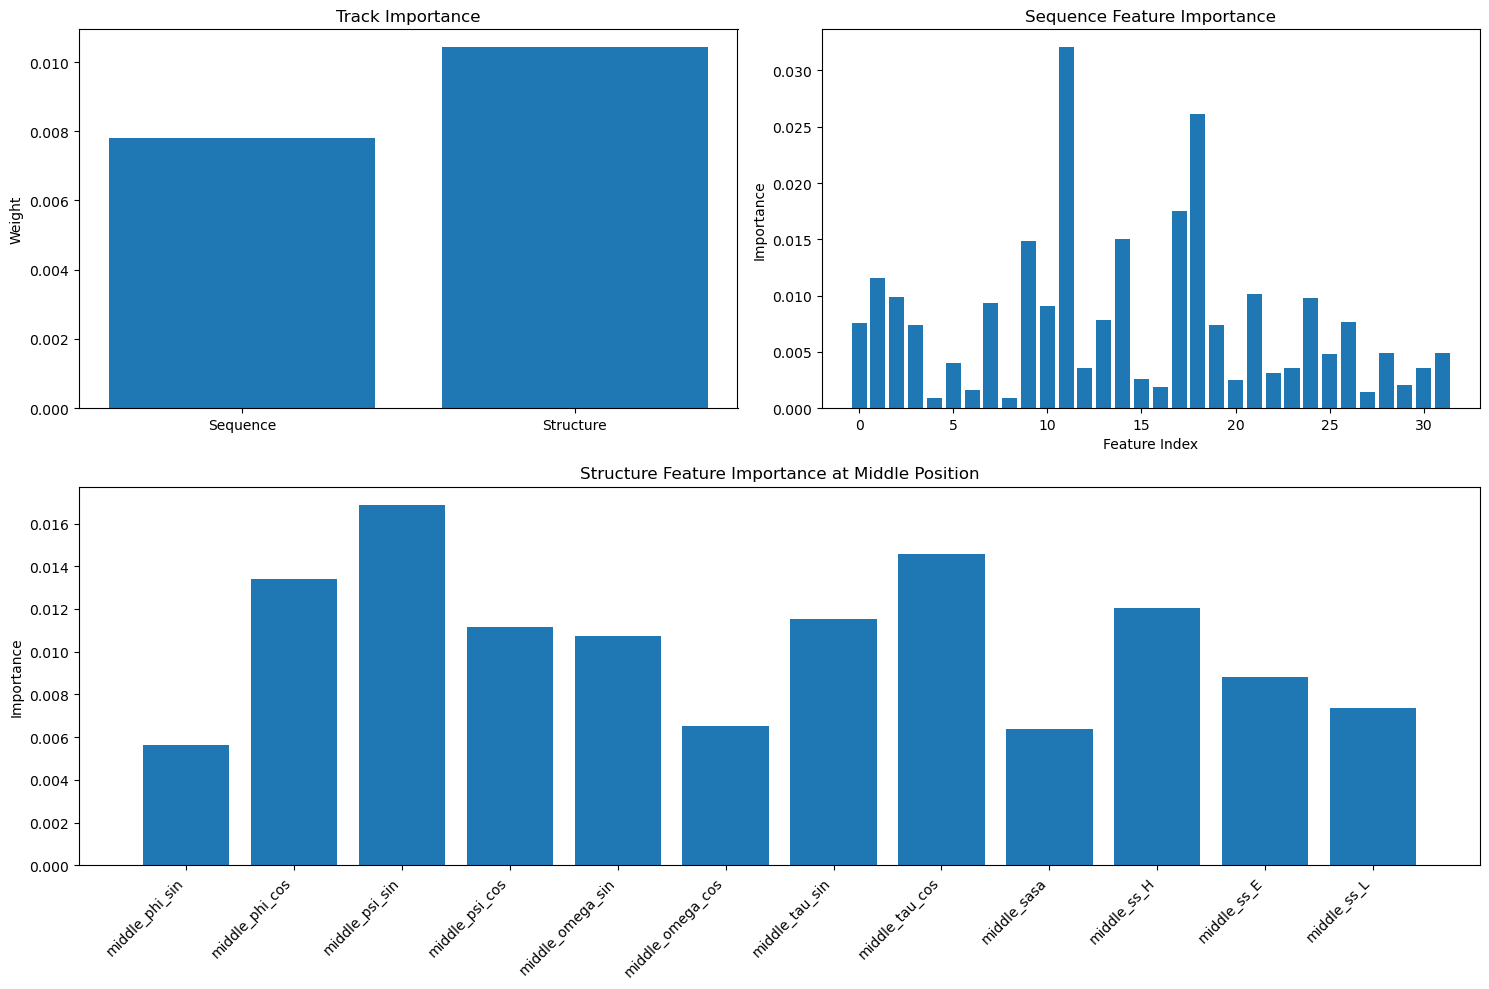

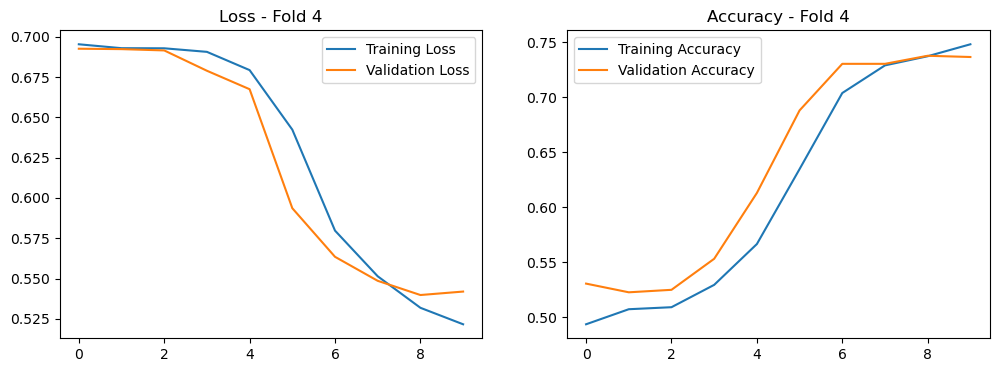

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5091 - loss: 0.6944 - val_accuracy: 0.5356 - val_loss: 0.6909 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5225 - loss: 0.6898 - val_accuracy: 0.5915 - val_loss: 0.6819 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6018 - loss: 0.6662 - val_accuracy: 0.6718 - val_loss: 0.6104 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6778 - loss: 0.6038 - val_accuracy: 0.7096 - val_loss: 0.5684 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7165 - loss: 0.5619 - val_accuracy: 0.7113 - val_loss: 0.5572 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7347 - loss: 0.5436 - val_accuracy: 0.7243 - val_loss: 0.5469 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7

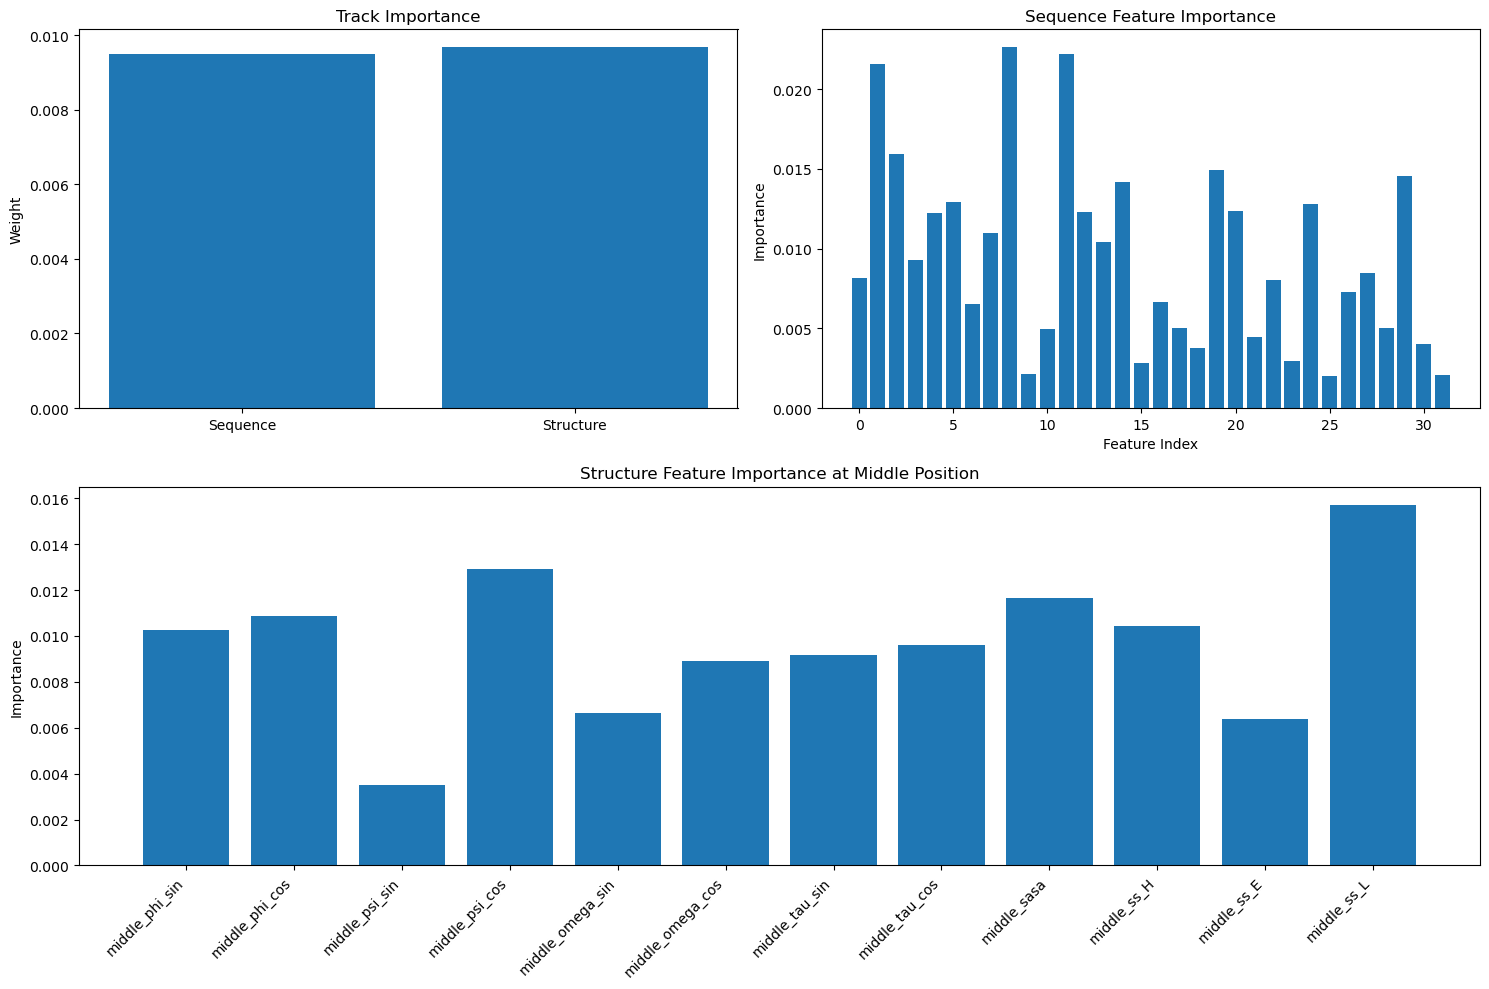

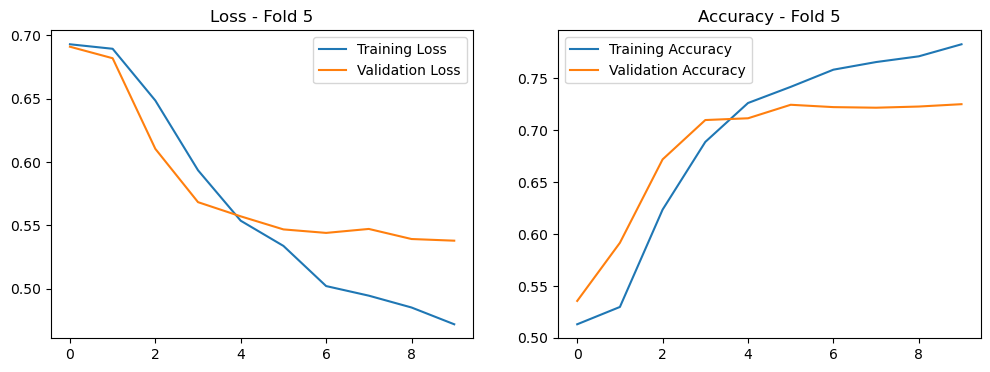

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Final Cross-validation Results:
ACC: 0.5780 ± 0.0816
BALANCED_ACC: 0.5695 ± 0.0836
MCC: 0.1501 ± 0.1696
SN: 0.7752 ± 0.0814
SP: 0.3637 ± 0.1449

Average Track Importance:
Sequence: 0.0089 ± 0.0011
Structure: 0.0099 ± 0.0005

Structure Features at Middle Position:
middle_phi_sin: 0.0092 ± 0.0032
middle_phi_cos: 0.0118 ± 0.0033
middle_psi_sin: 0.0095 ± 0.0046
middle_psi_cos: 0.0100 ± 0.0032
middle_omega_sin: 0.0101 ± 0.0033
middle_omega_cos: 0.0100 ± 0.0028
middle_tau_sin: 0.0099 ± 0.0016
middle_tau_cos: 0.0107 ± 0.0029
middle_sasa: 0.0090 ± 0.0024
middle_ss_H: 0.0117 ± 0.0015
middle_ss_E: 0.0089 ± 0.0016
middle_ss_L: 0.0087 ± 0.0037

Final Test Set Results:
Accuracy: 0.6306
Balanced Accuracy: 0.7335
MCC: 0.2667
Sensitivity: 0.8583
Specificity: 0.6087


In [10]:
if __name__ == "__main__":
    # Set window size
    window_size = 1  # or any other size you want to try
    print(f"Training model with window size: {window_size}")
    print(f"This will consider {2*window_size + 1} positions centered on the target residue")
    
    # Train model
    model, attention_history = train_and_evaluate(struct_window=window_size)